In [2]:
# Import các thư viện cần thiết
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Cài đặt để đồ thị hiển thị đẹp hơn
plt.style.use('fivethirtyeight')

In [3]:
# 1. Đọc và tiền xử lý dữ liệu
df = pd.read_csv("london_weather.csv")



In [4]:
# Thống kê dữ liệu thiếu
missing_data = df.isna().sum()
missing_data_percent = (missing_data / len(df)) * 100
statistic_missing_data = pd.DataFrame({
    "Missing Data Count": missing_data,
    "Missing Data Percent": missing_data_percent.round(2)
})
print("Thống kê dữ liệu thiếu: ")
statistic_missing_data
# Lấp đầy các giá trị bị thiếu bằng phương pháp forward-fill
df.fillna(method='ffill', inplace=True)

# Kiểm tra lại để chắc chắn không còn giá trị thiếu
print("\nSố lượng giá trị thiếu sau khi xử lý:")
print(df.isnull().sum())


Thống kê dữ liệu thiếu: 

Số lượng giá trị thiếu sau khi xử lý:
date                0
cloud_cover         0
sunshine            0
global_radiation    0
max_temp            0
mean_temp           0
min_temp            0
precipitation       0
pressure            0
snow_depth          0
dtype: int64


C:\Users\lenovo\AppData\Local\Temp\ipykernel_19332\2216763931.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [5]:
# Tạo một DataFrame mới để chuẩn bị cho Prophet
df_prophet = df.copy()

# Chuyển đổi cột 'date' sang định dạng datetime
# Định dạng '%Y%m%d' khớp với dữ liệu đầu vào (ví dụ: 19790101)
df_prophet['date'] = pd.to_datetime(df_prophet['date'], format='%Y%m%d')

# Đổi tên các cột theo yêu cầu của Prophet
df_prophet.rename(columns={'date': 'ds', 'mean_temp': 'y'}, inplace=True)

# Giữ lại các cột cần thiết cho mô hình cơ bản và nâng cao
# Các cột khác sẽ được dùng làm "regressors" (biến phụ) ở bước sau
final_df = df_prophet[['ds', 'y', 'cloud_cover', 'sunshine', 'global_radiation', 
                       'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']]

print("\nDữ liệu sau khi chuẩn bị cho Prophet:")
print(final_df.head())


Dữ liệu sau khi chuẩn bị cho Prophet:
          ds    y  cloud_cover  ...  precipitation  pressure  snow_depth
0 1979-01-01 -4.1          2.0  ...            0.4  101900.0         9.0
1 1979-01-02 -2.6          6.0  ...            0.0  102530.0         8.0
2 1979-01-03 -2.8          5.0  ...            0.0  102050.0         4.0
3 1979-01-04 -2.6          8.0  ...            0.0  100840.0         2.0
4 1979-01-05 -0.8          6.0  ...            0.0  102250.0         1.0

[5 rows x 10 columns]


In [6]:
# Chia dữ liệu: train tới cuối năm 2017, test từ 2018 trở đi
train_df = final_df[final_df['ds'] < '2018-01-01']
test_df = final_df[final_df['ds'] >= '2018-01-01']

print(f"Số dòng trong tập huấn luyện: {len(train_df)}")
print(f"Số dòng trong tập kiểm tra: {len(test_df)}")

# Chỉ lấy cột ds và y cho mô hình cơ bản
train_df_basic = train_df[['ds', 'y']]

Số dòng trong tập huấn luyện: 14245
Số dòng trong tập kiểm tra: 1096


In [7]:
# Khởi tạo và huấn luyện mô hình Prophet cơ bản
model_basic = Prophet()
model_basic.fit(train_df_basic)

12:19:52 - cmdstanpy - INFO - Chain [1] start processing
12:19:58 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Tạo một DataFrame cho tương lai, số ngày bằng với tập test
future_basic = model_basic.make_future_dataframe(periods=len(test_df))
print("\nKhung thời gian tương lai:")
print(future_basic.tail())


Khung thời gian tương lai:
              ds
15336 2020-12-27
15337 2020-12-28
15338 2020-12-29
15339 2020-12-30
15340 2020-12-31


In [9]:
# Dự báo trên khung thời gian tương lai
forecast_basic = model_basic.predict(future_basic)

# Hiển thị các cột dự báo
print("\nKết quả dự báo (cơ bản):")
print(forecast_basic[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


Kết quả dự báo (cơ bản):
              ds      yhat  yhat_lower  yhat_upper
15336 2020-12-27  6.704027    3.009644   10.498261
15337 2020-12-28  6.694537    2.946528   10.517835
15338 2020-12-29  6.635425    3.003111   10.306675
15339 2020-12-30  6.684623    3.236423   10.375500
15340 2020-12-31  6.633845    3.112819   10.408558


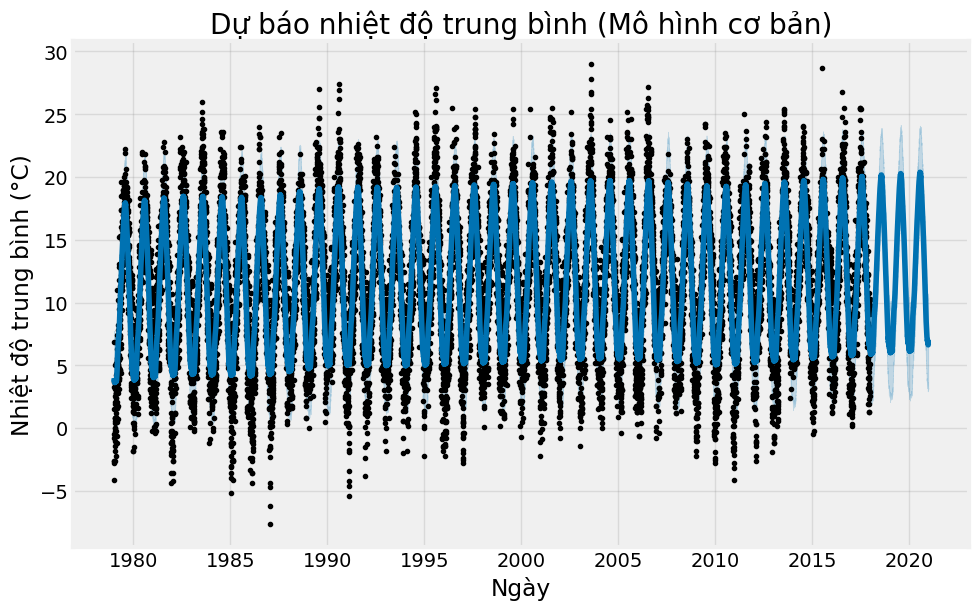

In [10]:
# Vẽ đồ thị dự báo
fig1 = model_basic.plot(forecast_basic)
plt.title("Dự báo nhiệt độ trung bình (Mô hình cơ bản)")
plt.xlabel("Ngày")
plt.ylabel("Nhiệt độ trung bình (°C)")
plt.show()

In [17]:
import numpy as np
# Lấy kết quả dự báo cho giai đoạn test
y_pred_basic = forecast_basic[-len(test_df):]['yhat']
y_true = test_df['y']

# Tính toán các chỉ số lỗi
mae_basic = mean_absolute_error(y_true, y_pred_basic)
mse_basic = mean_squared_error(y_true, y_pred_basic)
r2_basic = r2_score(y_true, y_pred_basic)
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape_basic = safe_mape(y_true, y_pred_basic)

print("\n--- Đánh giá mô hình cơ bản ---")
print(f"Mean Absolute Error (MAE): {mae_basic:.2f}")
print(f"Mean Squared Error (MSE): {mse_basic:.2f}")
print("MAPE:", round(mape_basic, 2), "%")
print(f"R-squared (R²): {r2_basic:.2f}")


--- Đánh giá mô hình cơ bản ---
Mean Absolute Error (MAE): 2.29
Mean Squared Error (MSE): 8.31
MAPE: 40.93 %
R-squared (R²): 0.76


In [12]:
# Chuẩn bị dữ liệu cho mô hình với regressors
regressor_cols = ['cloud_cover', 'sunshine', 'global_radiation', 
                  'max_temp', 'min_temp', 'precipitation', 'pressure', 'snow_depth']

train_df_reg = train_df[['ds', 'y'] + regressor_cols]
test_df_reg = test_df[['ds', 'y'] + regressor_cols]

# Khởi tạo mô hình mới
model_reg = Prophet()

# Thêm các regressors vào mô hình
for col in regressor_cols:
    model_reg.add_regressor(col)

# Huấn luyện mô hình nâng cao
model_reg.fit(train_df_reg)

12:20:02 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Tạo future dataframe, lần này nó phải chứa cả các cột regressor
future_reg = model_reg.make_future_dataframe(periods=len(test_df_reg))

# Ghép các giá trị regressor vào future dataframe
future_reg = pd.merge(future_reg, final_df[['ds'] + regressor_cols], on='ds', how='left')

print("\nKhung thời gian tương lai với Regressors:")
print(future_reg.tail())

# Dự báo với mô hình nâng cao
forecast_reg = model_reg.predict(future_reg)


Khung thời gian tương lai với Regressors:
              ds  cloud_cover  sunshine  ...  precipitation  pressure  snow_depth
15336 2020-12-27          1.0       0.9  ...            2.0   98000.0         0.0
15337 2020-12-28          7.0       3.7  ...            0.2   97370.0         0.0
15338 2020-12-29          7.0       0.0  ...            0.0   98830.0         0.0
15339 2020-12-30          6.0       0.4  ...            0.0  100200.0         0.0
15340 2020-12-31          7.0       1.3  ...            0.0  100500.0         0.0

[5 rows x 9 columns]


In [18]:
# Lấy kết quả dự báo
y_pred_reg = forecast_reg[-len(test_df):]['yhat']

# Tính toán các chỉ số lỗi
mae_reg = mean_absolute_error(y_true, y_pred_reg)
mse_reg = mean_squared_error(y_true, y_pred_reg)
r2_reg = r2_score(y_true, y_pred_reg)
mape_reg = safe_mape(y_true, y_pred_reg)

print("\n--- Đánh giá mô hình nâng cao (với Regressors) ---")
print(f"Mean Absolute Error (MAE): {mae_reg:.2f}")
print(f"Mean Squared Error (MSE): {mse_reg:.2f}")
print(f"R-squared (R²): {r2_reg:.2f}")
print("MAPE:", round(mape_reg, 2), "%")
# So sánh hai mô hình
print("\n--- So sánh kết quả ---")
print(f"R² Cơ bản: {r2_basic:.2f} vs R² Nâng cao: {r2_reg:.2f}")
print(f"MAE Cơ bản: {mae_basic:.2f} vs MAE Nâng cao: {mae_reg:.2f}")


--- Đánh giá mô hình nâng cao (với Regressors) ---
Mean Absolute Error (MAE): 0.78
Mean Squared Error (MSE): 1.17
R-squared (R²): 0.97
MAPE: 9.64 %

--- So sánh kết quả ---
R² Cơ bản: 0.76 vs R² Nâng cao: 0.97
MAE Cơ bản: 2.29 vs MAE Nâng cao: 0.78


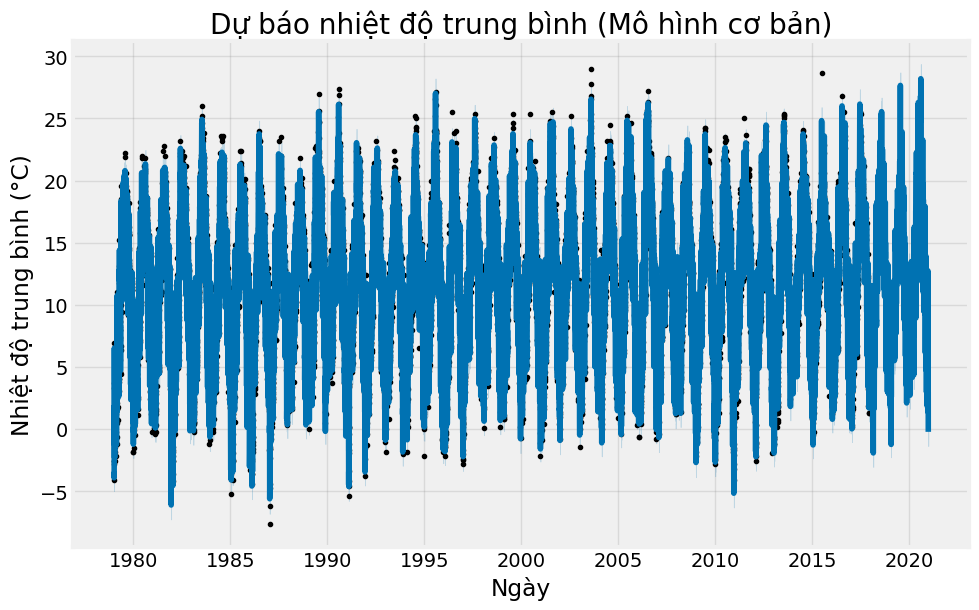

In [19]:
# Vẽ đồ thị dự báo
fig1 = model_reg.plot(forecast_reg)
plt.title("Dự báo nhiệt độ trung bình (Mô hình cơ bản)")
plt.xlabel("Ngày")
plt.ylabel("Nhiệt độ trung bình (°C)")
plt.show()